## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

import cv2
import matplotlib.pyplot as plt

## Шаг 1: Подготовка данных

In [2]:
train = np.loadtxt('./Series/MNIST_train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./Series/MNIST_test.csv', delimiter=',', skiprows=1)

train.shape, test.shape

((42000, 785), (28000, 784))

In [3]:
# сохраняем разметку в отдельную переменную
train_labels = train[:, 0]

# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

train_img.shape, train_labels.shape, test_img.shape

((42000, 28, 28), (42000,), (28000, 28, 28))

In [4]:
# преобразовываем в torch.Tesnor

train_dataset = torch.from_numpy(train_img, ).to(torch.uint8)
test_dataset = torch.from_numpy(test_img, ).to(torch.uint8)
train_labels = torch.Tensor(train_labels).to(torch.uint8)

train_dataset.shape, test_dataset.shape

(torch.Size([42000, 28, 28]), torch.Size([28000, 28, 28]))

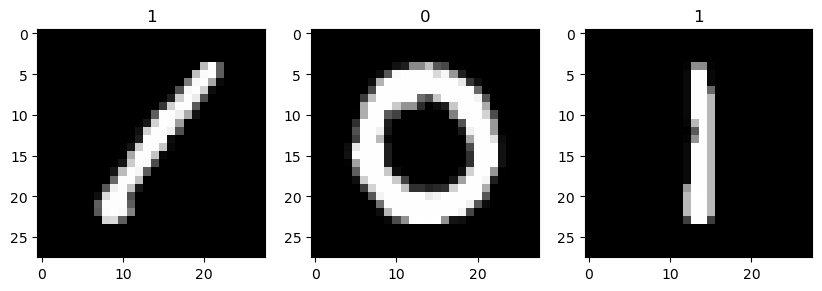

In [5]:
data, labels = train_dataset.data[0:3], train_labels[0:3].numpy()

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,5)

for i in range(3):
    ax[i].imshow(data[i], cmap='gray')
    ax[i].set_title(labels[i]);

## Шаг 2: Предобработка изображений. PCA для сокращения размерности

In [6]:
train_features = train_dataset.data.reshape(-1, 28*28).numpy()
test_features = test_dataset.data.reshape(-1, 28*28).numpy()

In [7]:
train_features.shape, test_features.shape

((42000, 784), (28000, 784))

In [8]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [9]:
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

In [10]:
train_features_pca.shape, test_features_pca.shape

((42000, 100), (28000, 100))

In [11]:
# train_labels = train_dataset.targets
# test_labels = test_dataset.targets

train_dataset_pca = torch.utils.data.TensorDataset(torch.from_numpy(train_features_pca).float(), train_labels)
# test_dataset_pca = torch.utils.data.TensorDataset(torch.from_numpy(test_features_pca).float(), test_labels)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset_pca, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset_pca, batch_size=64, shuffle=False)

## Шаг 3: Создание модели 

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.bn(out)
        out = self.fc2(out)
        return out

In [14]:
input_size = train_features_pca.shape[1]
hidden_size = 256
num_classes = 10

In [15]:
model = MLP(input_size, hidden_size, num_classes)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [17]:
num_epochs = 10
for epoch in range(num_epochs):
    for features, labels in train_loader:
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 0.12027866393327713
Epoch [2/10], Loss: 0.6907888054847717
Epoch [3/10], Loss: 0.039229921996593475
Epoch [4/10], Loss: 0.10188154876232147
Epoch [5/10], Loss: 0.02106158249080181
Epoch [6/10], Loss: 0.021771112456917763
Epoch [7/10], Loss: 0.09307211637496948
Epoch [8/10], Loss: 0.002721802331507206
Epoch [9/10], Loss: 0.02361186407506466
Epoch [10/10], Loss: 0.057856108993291855


## Оценка модели и запись предсказаний в файл

In [18]:
test_dataset_pca = torch.utils.data.TensorDataset(torch.from_numpy(test_features_pca).float())
test_loader = torch.utils.data.DataLoader(test_dataset_pca, batch_size=64, shuffle=False)

predictions = []
with torch.no_grad():
    for features in test_loader:
        outputs = model(features[0])
        _, pred = torch.max(outputs.data, 1)
        predictions.extend(pred.tolist())
len(predictions)

28000

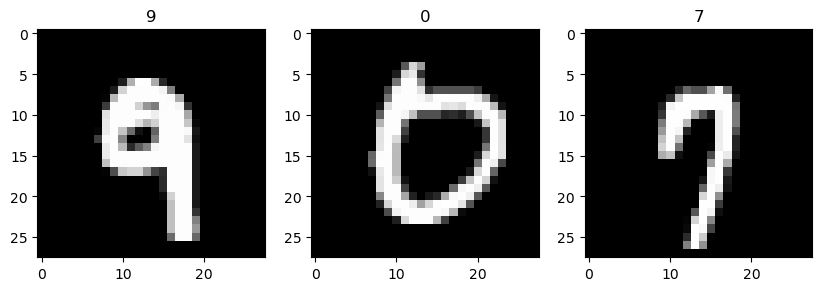

In [19]:
a = 999

data, labels = test_dataset.data[a:a+3], predictions[a:a+3]

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,5)

for i in range(3):
    ax[i].imshow(data[i], cmap='gray')
    ax[i].set_title(labels[i]);

In [21]:
with open('submit.csv', 'w') as file:
    file.write('ImageId,Label\n')
    for i, p in enumerate(predictions, 1):
        print(f'{i},{p}', file=file)